In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import skimage.transform as tf
import scipy.signal as signal
import re
import sys
def atoi(text):
    return int(text) if text.isdigit() else text.lower()
    
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [4]:
filelist = glob.glob('figs/A/*.tiff')
filelist.sort(key=natural_keys)
print(filelist)
A_array = np.array([np.array(cv2.imread(fname, 0)) for fname in filelist])

['figs/A/Dark_amp.tiff', 'figs/A/Illumination_amp.tiff', 'figs/A/ITOfloating_amp.tiff', 'figs/A/Mofloating_amp.tiff']


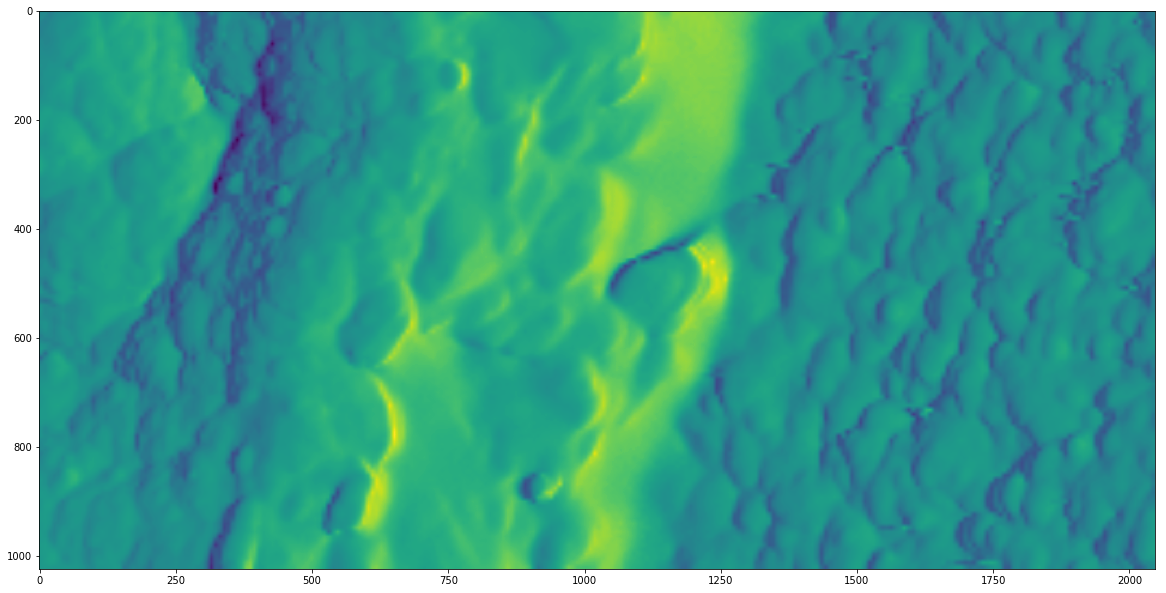

In [5]:
height, width = A_array[0].shape
dark_upsample = cv2.resize(A_array[0], (width*8, height*8), cv2.INTER_LANCZOS4)
plt.figure(figsize=(20,20))
plt.imshow(dark_upsample)
plt.show()

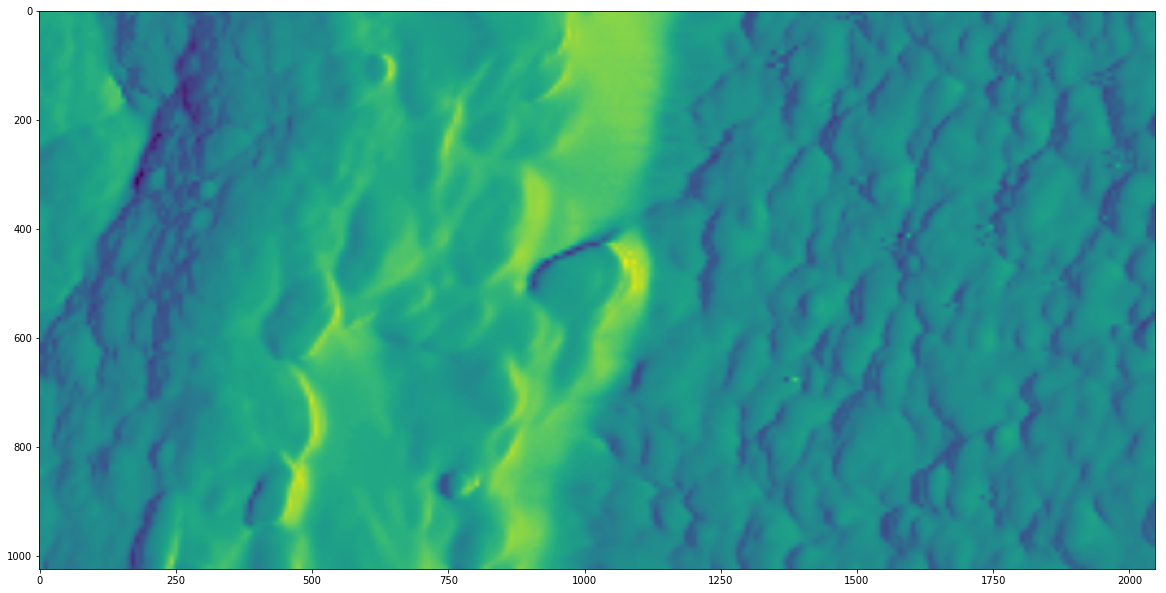

In [6]:
height, width = A_array[1].shape
illumination_upsample = cv2.resize(A_array[1], (width*8, height*8), cv2.INTER_LANCZOS4)
plt.figure(figsize=(20,20))
plt.imshow(illumination_upsample)
plt.show()

In [7]:
import numpy as np
from dipy.data import get_data
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

In [10]:
dim = dark_upsample.ndim
metric = SSDMetric(dim)

level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [ ]:
mapping = sdr.optimize(dark_upsample, illumination_upsample)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


In [ ]:
warped = mapping.transform(moving)